# Modelling for predicting World Cup and Euro results from qualification performance

Dependencies

In [1]:
import pandas as pd
import numpy as np

Data as prepared in relevant notebooks and saved as pickle.

In [2]:
df_main = pd.read_pickle("../data/processed/qualification_performance.pkl")
df_main.info() ; df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  997 non-null    datetime64[ns]
 1   team_A                997 non-null    object        
 2   team_B                997 non-null    object        
 3   A_score               997 non-null    int64         
 4   B_score               997 non-null    int64         
 5   tournament            997 non-null    object        
 6   city                  997 non-null    object        
 7   country               997 non-null    object        
 8   neutral               997 non-null    bool          
 9   period                997 non-null    object        
 10  host_advantage        997 non-null    object        
 11  A_win_ratio           997 non-null    float64       
 12  A_draw_ratio          997 non-null    float64       
 13  A_avg_goals_scored  

,date,team_A,team_B,A_score,B_score,tournament,city,country,neutral,period,host_advantage,A_win_ratio,A_draw_ratio,A_avg_goals_scored,A_avg_goals_conceded,B_win_ratio,B_draw_ratio,B_avg_goals_scored,B_avg_goals_conceded,result
0,1978-06-01,Germany,Poland,0,0,FIFA World Cup,Buenos Aires,Argentina,True,WC78,No,0.647059,0.176471,1.823529,0.823529,0.631579,0.105263,2.157895,1.263158,Draw
1,1978-06-02,Argentina,Hungary,2,1,FIFA World Cup,Buenos Aires,Argentina,False,WC78,Yes,0.619048,0.238095,1.714286,0.809524,0.523810,0.285714,2.047619,1.428571,A_win
2,1978-06-02,Tunisia,Mexico,3,1,FIFA World Cup,Rosario,Argentina,True,WC78,No,0.370370,0.296296,1.333333,1.185185,0.550000,0.250000,2.150000,0.850000,A_win
3,1978-06-02,France,Italy,1,2,FIFA World Cup,Mar del Plata,Argentina,True,WC78,No,0.562500,0.375000,1.625000,0.625000,0.600000,0.133333,2.000000,0.866667,B_win
4,1978-06-03,Spain,Austria,1,2,FIFA World Cup,Buenos Aires,Argentina,True,WC78,No,0.727273,0.181818,1.363636,0.363636,0.555556,0.222222,1.777778,0.777778,B_win


## Preparing training and test datasets

We will look at the last tournament, Euro 24, separately. So we keep it apart from other datasets.

In [3]:
#df_unseen = df_main[df_main["period"] == "Euro24"].copy()
df_main = df_main[df_main["period"] != "Euro24"].copy()

Since the point is to predict new events with historical data, we define training and test sets with a cut-off in time. 

In [4]:
df_main["year"] = df_main["date"].dt.year
df_main.value_counts("year", sort = False).sort_index(ascending = False).cumsum()

year
2022     64
2021    115
2018    179
2016    230
2014    294
2012    325
2010    389
2008    420
2004    451
2002    515
2000    546
1998    610
1996    641
1994    693
1992    708
1990    760
1988    775
1986    827
1984    842
1982    894
1980    908
1978    946
Name: count, dtype: int64

We use 2016 as the cut-off, with 230 matches in the test set, roughly 24%.

In [5]:
df_train = df_main[df_main["year"] < 2016].copy()
df_test = df_main[df_main["year"] >= 2016].copy()

Finally, we separate target and features.

In [6]:
feature_names = []

for ab in ["A", "B"]:
    for metric in ["win_ratio", "draw_ratio", "avg_goals_scored", "avg_goals_conceded"]:
        feature_names.append(f"{ab}_{metric}")

feature_names.append("host_advantage")

In [7]:
X_train = df_train[feature_names] ; X_test = df_test[feature_names]
y_train = df_train[["result"]] ; y_test = df_test[["result"]]

## Comparing potential models

We set up a pycaret workflow to compare possible classification models. We apply a time series logic in the setup, in line withe the train-test split.

In [8]:
from pycaret.classification import *

In [9]:
clf = setup(
    data = pd.concat([X_train, y_train], axis = 1),
    target = "result",
    session_id = 42, 
    test_data = pd.concat([X_test, y_test], axis = 1),
    experiment_name = "qual_perf_model",
    n_jobs = -1, 
    train_size = 0.75, 
    index = False,
    fix_imbalance = True,
    normalize = True, 
    data_split_shuffle = False, 
    fold_shuffle = False, 
    fold_strategy = "timeseries"
)

,Description,Value
0,Session id,42
1,Target,result
2,Target type,Multiclass
3,Target mapping,"A_win: 0, B_win: 1, Draw: 2"
4,Original data shape,"(946, 10)"
5,Transformed data shape,"(1079, 10)"
6,Transformed train set shape,"(849, 10)"
7,Transformed test set shape,"(230, 10)"
8,Numeric features,8
9,Categorical features,1


In [10]:
model_selection = compare_models(sort = "f1", exclude = ["lightgbm", "catboost"]) # exclude lightgbm and catboost because they are too slow

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4369,0.0000,0.4369,0.4646,0.4343,0.1472,0.1518,0.0260
lr,Logistic Regression,0.4308,0.0000,0.4308,0.4550,0.4297,0.1378,0.1414,0.4350
lda,Linear Discriminant Analysis,0.4292,0.0000,0.4292,0.4563,0.4289,0.1377,0.1417,0.0290
nb,Naive Bayes,0.4231,0.6068,0.4231,0.4564,0.4163,0.1322,0.1376,0.0270
qda,Quadratic Discriminant Analysis,0.4123,0.0000,0.4123,0.4333,0.4065,0.1051,0.1093,0.0280
et,Extra Trees Classifier,0.3938,0.5870,0.3938,0.4108,0.3839,0.0753,0.0774,0.0720
dt,Decision Tree Classifier,0.3815,0.5341,0.3815,0.4003,0.3821,0.0624,0.0646,0.0270
ada,Ada Boost Classifier,0.3831,0.0000,0.3831,0.4082,0.3812,0.0663,0.0679,0.0660
rf,Random Forest Classifier,0.3846,0.5764,0.3846,0.4120,0.3800,0.0638,0.0655,0.0860
knn,K Neighbors Classifier,0.3738,0.5617,0.3738,0.3983,0.3799,0.0498,0.0506,0.0360


We will proceed with ridge and LR for hyperparameter tuning (LDA, QDA and NB are not tunable in the same way).

### Hyperparameter tuning for ridge classifier

In [11]:
model_ridge = create_model("ridge")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3231,0.0000,0.3231,0.3817,0.3256,0.0111,0.0119
1,0.3538,0.0000,0.3538,0.4413,0.3559,0.0827,0.0932
2,0.3846,0.0000,0.3846,0.3846,0.3845,0.0497,0.0497
3,0.4154,0.0000,0.4154,0.4348,0.4183,0.0852,0.0864
4,0.4462,0.0000,0.4462,0.5268,0.4258,0.1781,0.1978
5,0.4615,0.0000,0.4615,0.4651,0.4603,0.1654,0.1667
6,0.5077,0.0000,0.5077,0.5203,0.5017,0.2555,0.2628
7,0.4615,0.0000,0.4615,0.4777,0.4677,0.1831,0.1840
8,0.5846,0.0000,0.5846,0.5814,0.5805,0.3395,0.3412


In [12]:
model_ridge_tuned = tune_model(
    model_ridge,
    optimize = "f1", 
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "alpha": np.logspace(-2, 2, 21).tolist()
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3385,0.0000,0.3385,0.4159,0.3505,0.0309,0.0328
1,0.3692,0.0000,0.3692,0.4083,0.3641,0.0851,0.0914
2,0.3846,0.0000,0.3846,0.3886,0.3850,0.0587,0.0589
3,0.4615,0.0000,0.4615,0.4519,0.4551,0.1447,0.1454
4,0.4769,0.0000,0.4769,0.5883,0.4539,0.2227,0.2474
5,0.4308,0.0000,0.4308,0.4347,0.4292,0.1219,0.1231
6,0.4923,0.0000,0.4923,0.5076,0.4834,0.2301,0.2396
7,0.4462,0.0000,0.4462,0.4502,0.4480,0.1509,0.1510
8,0.6000,0.0000,0.6000,0.5960,0.5963,0.3618,0.3630


Fitting 10 folds for each of 21 candidates, totalling 210 fits


### Hyperparameter tuning for logistic regression

In [13]:
model_lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3077,0.0000,0.3077,0.3694,0.3118,-0.0167,-0.0179
1,0.3538,0.0000,0.3538,0.4205,0.3619,0.0683,0.0740
2,0.3846,0.0000,0.3846,0.3846,0.3845,0.0497,0.0497
3,0.4000,0.0000,0.4000,0.4123,0.4000,0.0611,0.0620
4,0.4615,0.0000,0.4615,0.5136,0.4407,0.2004,0.2196
5,0.4308,0.0000,0.4308,0.4391,0.4320,0.1283,0.1292
6,0.4923,0.0000,0.4923,0.5047,0.4898,0.2345,0.2389
7,0.4923,0.0000,0.4923,0.5128,0.4993,0.2331,0.2349
8,0.5692,0.0000,0.5692,0.5669,0.5643,0.3173,0.3196


In [14]:
model_lr_tuned = tune_model(
    model_lr,
    optimize = "f1", 
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "penalty": ["l1", "l2"],
        "C": np.logspace(-2, 2, 21).tolist(),
        "solver" : ["liblinear"], 
        "class_weight" : ["balanced", None]
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3538,0.0000,0.3538,0.4270,0.3637,0.0518,0.0550
1,0.3692,0.0000,0.3692,0.4427,0.3698,0.0969,0.1068
2,0.3538,0.0000,0.3538,0.3497,0.3497,0.0044,0.0044
3,0.4308,0.0000,0.4308,0.4353,0.4290,0.0989,0.0999
4,0.4615,0.0000,0.4615,0.5266,0.4309,0.2006,0.2244
5,0.4462,0.0000,0.4462,0.4497,0.4455,0.1447,0.1456
6,0.5077,0.0000,0.5077,0.5246,0.5016,0.2545,0.2632
7,0.4462,0.0000,0.4462,0.4531,0.4492,0.1525,0.1526
8,0.6000,0.0000,0.6000,0.5960,0.5963,0.3618,0.3630


Fitting 10 folds for each of 84 candidates, totalling 840 fits


In [15]:
model_lr_tuned_elasticnet = tune_model(
    model_lr,
    optimize = "f1", 
    search_library = "scikit-optimize",
    search_algorithm = "bayesian", 
    custom_grid = {
        "penalty": ["elasticnet"],
        "C": np.logspace(-2, 2, 21).tolist(),
        "l1_ratio" : np.linspace(0, 1, 11).tolist(),
        "solver" : ["saga"], 
        "class_weight" : ["balanced", None]
    }, 
    fold = 10, 
    n_iter = 50
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3538,0.0000,0.3538,0.4137,0.3617,0.0424,0.0448
1,0.3692,0.0000,0.3692,0.4271,0.3681,0.0923,0.1006
2,0.3846,0.0000,0.3846,0.3858,0.3846,0.0504,0.0505
3,0.4615,0.0000,0.4615,0.4683,0.4605,0.1476,0.1491
4,0.4769,0.0000,0.4769,0.5349,0.4627,0.2227,0.2411
5,0.4308,0.0000,0.4308,0.4391,0.4320,0.1283,0.1292
6,0.5077,0.0000,0.5077,0.5175,0.5021,0.2566,0.2626
7,0.4769,0.0000,0.4769,0.4938,0.4835,0.2065,0.2074
8,0.5692,0.0000,0.5692,0.5667,0.5666,0.3171,0.3179


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

The LR model tuned with elasticnet regularisation displays the best performance.

### Evaluation

In [16]:
evaluate_model(model_lr_tuned_elasticnet)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
test_pred = predict_model(model_lr_tuned_elasticnet)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.4304,0.6227,0.4304,0.4395,0.4344,0.1310,0.1312


F1 from the hold-out set is a little lower than cross validation scores.

The model is quite bad at predicting draws (class 2).

Given the overall low accuracy, and unbalanced prediction between classes, we should take a closer look at prediction probabilities.

<Axes: >

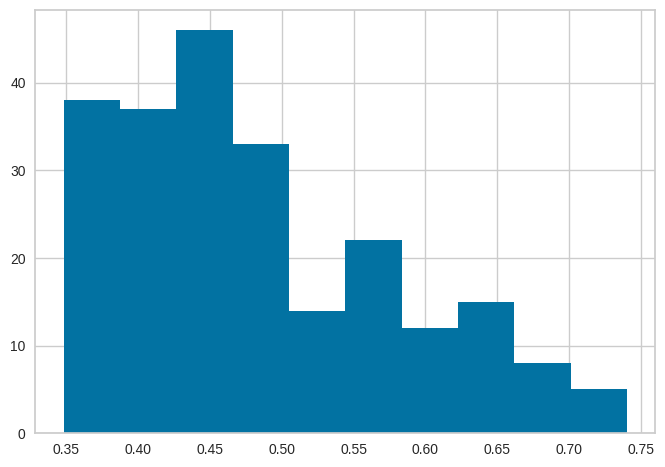

In [18]:
test_pred["prediction_score"].hist()

Most predicions are made with a probability lower than 50%, which is not very useful.

## Model deployment

In [19]:
model_lr_final = finalize_model(model_lr_tuned_elasticnet)
save_model(model_lr_final, "../models/qual_perf_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['A_win_ratio', 'A_draw_ratio',
                                              'A_avg_goals_scored',
                                              'A_avg_goals_conceded',
                                              'B_win_ratio', 'B_draw_ratio',
                                              'B_avg_goals_scored',
                                              'B_avg_goals_conc...
                                     transformer=StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))),
                